In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 被験者ID
subject_id = "001"
# 実験番号
experiment_id = "001"

# IDT法のパラメータ
VELOCITY_THRESHOLD = 30 # deg
DURATION_THRESHOLD_MS = 100  # ms

eye_df = pd.read_csv(f"exported_csv/eye_df_id{subject_id}-{experiment_id}.csv")
sampling_df = pd.read_csv(f"exported_csv/sampling_df_id{subject_id}-{experiment_id}.csv")

In [2]:

# パラメータ（固定）
monitor_width_cm = 47.6
monitor_height_cm = 26.8
monitor_resolution_px = (1920, 1080)
viewer_distance_cm = 60.0

cm_per_pixel_x = monitor_width_cm / monitor_resolution_px[0]
cm_per_pixel_y = monitor_height_cm / monitor_resolution_px[1]

In [3]:

# 座標変換（正規化→度単位）
eye_df["gx_centered"] = eye_df["gx"] - 0.5
eye_df["gy_centered"] = eye_df["gy"] - 0.5

eye_df["x_cm"] = eye_df["gx_centered"] * monitor_resolution_px[0] * cm_per_pixel_x
eye_df["y_cm"] = eye_df["gy_centered"] * monitor_resolution_px[1] * cm_per_pixel_y

eye_df["x_deg"] = np.degrees(np.arctan2(eye_df["x_cm"], viewer_distance_cm))
eye_df["y_deg"] = np.degrees(np.arctan2(eye_df["y_cm"], viewer_distance_cm))

eye_df["is_valid"] = eye_df["validity_sum"] < 2


In [4]:
# Step 1: 欠損補完（100ms以下 → 線形補完、100ms超 → 分割）
def interpolate_missing(data, time_col="epoch_sec", max_gap_ms=100):
    data = data.copy()
    data["valid"] = data["is_valid"] & data["x_deg"].notna() & data["y_deg"].notna()
    data["interp_x"] = np.nan
    data["interp_y"] = np.nan

    # 有効データを代入
    data.loc[data["valid"], "interp_x"] = data.loc[data["valid"], "x_deg"]
    data.loc[data["valid"], "interp_y"] = data.loc[data["valid"], "y_deg"]

    # 内部のみ線形補完
    data["interp_x"] = data["interp_x"].interpolate(limit_area="inside")
    data["interp_y"] = data["interp_y"].interpolate(limit_area="inside")

    # 無効区間の連続ブロックを取得
    invalid_mask = ~data["valid"]
    group_id = (invalid_mask != invalid_mask.shift()).cumsum()
    invalid_blocks = data[invalid_mask].groupby(group_id)

    for _, block in invalid_blocks:
        if len(block) == 0:
            continue
        t_start = block[time_col].iloc[0]
        t_end = block[time_col].iloc[-1]
        duration_ms = (t_end - t_start) * 1000
        if duration_ms > max_gap_ms:
            # 100ms超えたら補完結果をNaNに戻す
            data.loc[block.index, ["interp_x", "interp_y"]] = np.nan

    return data

In [5]:
def detect_fixations_ivt(df, velocity_threshold=VELOCITY_THRESHOLD, duration_threshold_ms=DURATION_THRESHOLD_MS):
    fixations = []
    timestamps = df["epoch_sec"].values
    xs = df["interp_x"].values
    ys = df["interp_y"].values

    # 速度（deg/s）を計算
    velocities = np.sqrt(np.diff(xs)**2 + np.diff(ys)**2) / np.diff(timestamps)
    velocities = np.insert(velocities, 0, 0)  # 最初の点の速度は0とする

    in_fixation = False
    start_idx = 0

    for i in range(len(df)):
        if np.isnan(xs[i]) or np.isnan(ys[i]):
            if in_fixation:
                # 注視の終了
                in_fixation = False
                t_start = timestamps[start_idx]
                t_end = timestamps[i - 1]
                duration = (t_end - t_start) * 1000
                if duration >= duration_threshold_ms:
                    fixations.append({
                        "start_time": t_start,
                        "end_time": t_end,
                        "duration_ms": duration,
                        "x_mean_deg": np.mean(xs[start_idx:i]),
                        "y_mean_deg": np.mean(ys[start_idx:i]),
                    })
            continue

        if velocities[i] < velocity_threshold:
            if not in_fixation:
                in_fixation = True
                start_idx = i
        else:
            if in_fixation:
                in_fixation = False
                t_start = timestamps[start_idx]
                t_end = timestamps[i - 1]
                duration = (t_end - t_start) * 1000
                if duration >= duration_threshold_ms:
                    fixations.append({
                        "start_time": t_start,
                        "end_time": t_end,
                        "duration_ms": duration,
                        "x_mean_deg": np.mean(xs[start_idx:i]),
                        "y_mean_deg": np.mean(ys[start_idx:i]),
                    })

    # 最後が注視で終わっていた場合
    if in_fixation:
        t_start = timestamps[start_idx]
        t_end = timestamps[-1]
        duration = (t_end - t_start) * 1000
        if duration >= duration_threshold_ms:
            fixations.append({
                "start_time": t_start,
                "end_time": t_end,
                "duration_ms": duration,
                "x_mean_deg": np.mean(xs[start_idx:]),
                "y_mean_deg": np.mean(ys[start_idx:]),
            })

    return pd.DataFrame(fixations)


In [6]:
def deg2px(x_deg, y_deg):
    x_cm = np.tan(np.radians(x_deg)) * viewer_distance_cm
    y_cm = np.tan(np.radians(y_deg)) * viewer_distance_cm
    x_px = (x_cm / cm_per_pixel_x) + (monitor_resolution_px[0] / 2)
    y_px = (y_cm / cm_per_pixel_y) + (monitor_resolution_px[1] / 2)
    return x_px, y_px


**************************************
     start_time      end_time  duration_ms  x_mean_deg  y_mean_deg  trial  \
0  1.732521e+09  1.732521e+09   967.999935    0.754095   11.347582    0.0   
1  1.732521e+09  1.732521e+09  7302.000046   -2.958114    4.213122    0.0   
2  1.732521e+09  1.732521e+09  1435.000181    4.410953   -0.792719    0.0   
3  1.732521e+09  1.732521e+09   796.999931   -0.638989    7.806569    0.0   
4  1.732521e+09  1.732521e+09   760.999918    1.688049    8.781077    0.0   
5  1.732521e+09  1.732521e+09  3119.999886   -3.952174    8.336159    0.0   
6  1.732521e+09  1.732521e+09  3733.000040   -4.070542    4.861042    0.0   
7  1.732521e+09  1.732521e+09  5838.999987   -5.047441    8.525508    0.0   
8  1.732521e+09  1.732521e+09  5444.000006   -4.140250    5.560581    0.0   

          x_px         y_px  
0   991.854738  1025.234710  
1   834.938407   718.116991  
2  1146.687184   506.544709  
3   933.008045   871.494936  
4  1031.323659   913.494640  
5   792.79

C:\Users\hisao\AppData\Local\Temp\ipykernel_3920\3294026227.py:8: RuntimeWarning: divide by zero encountered in divide
  velocities = np.sqrt(np.diff(xs)**2 + np.diff(ys)**2) / np.diff(timestamps)
C:\Users\hisao\AppData\Local\Temp\ipykernel_3920\3294026227.py:8: RuntimeWarning: invalid value encountered in divide
  velocities = np.sqrt(np.diff(xs)**2 + np.diff(ys)**2) / np.diff(timestamps)


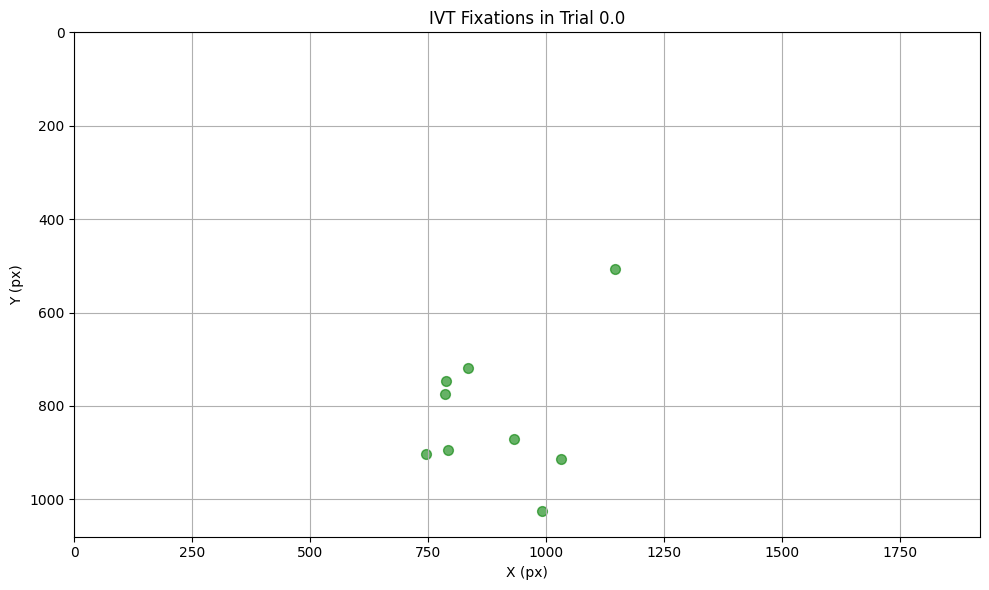

**************************************
     start_time      end_time  duration_ms  x_mean_deg  y_mean_deg  trial  \
0  1.732521e+09  1.732521e+09  3934.000015   -4.647694    2.323857    1.0   
1  1.732521e+09  1.732521e+09  1609.999895   -3.367863    8.874393    1.0   
2  1.732521e+09  1.732521e+09  2058.000088   10.427600   10.505242    1.0   
3  1.732521e+09  1.732521e+09  2991.999865  -11.488504   -0.592995    1.0   
4  1.732521e+09  1.732521e+09  3206.000090   -0.280365    7.606241    1.0   
5  1.732521e+09  1.732521e+09   649.999857   -9.329105    3.222889    1.0   
6  1.732521e+09  1.732521e+09  5547.000170   -3.489508    7.226328    1.0   
7  1.732521e+09  1.732521e+09  1664.999962   -6.266696    8.534863    1.0   
8  1.732521e+09  1.732521e+09  2848.000050   -3.069137   12.333572    1.0   

          x_px         y_px  
0   763.250152   638.121720  
1   817.577744   917.527609  
2  1405.389138   988.362024  
3   468.116907   514.974441  
4   948.157326   862.886213  
5   562.41

C:\Users\hisao\AppData\Local\Temp\ipykernel_3920\3294026227.py:8: RuntimeWarning: divide by zero encountered in divide
  velocities = np.sqrt(np.diff(xs)**2 + np.diff(ys)**2) / np.diff(timestamps)


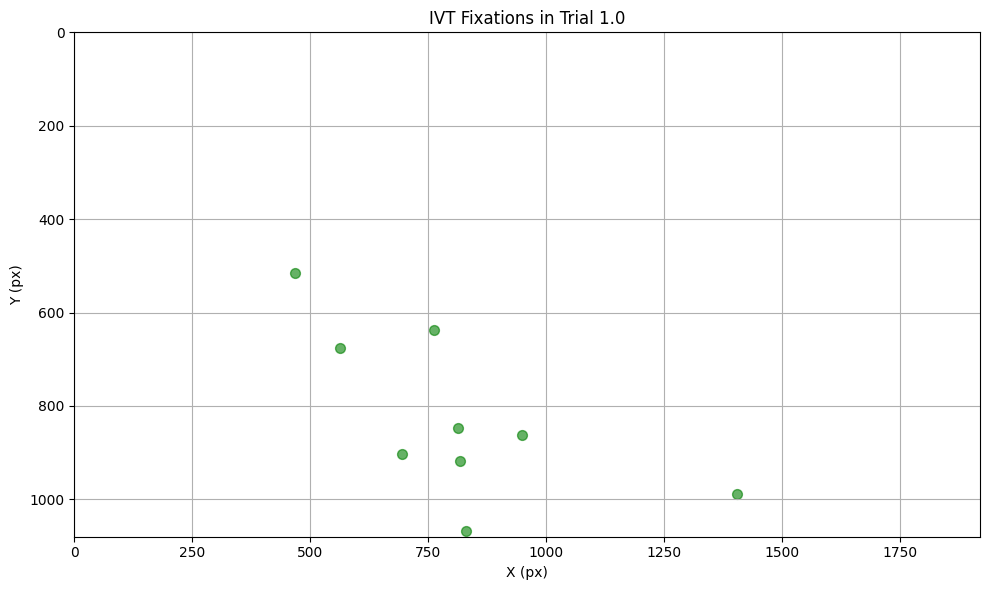

C:\Users\hisao\AppData\Local\Temp\ipykernel_3920\3294026227.py:8: RuntimeWarning: divide by zero encountered in divide
  velocities = np.sqrt(np.diff(xs)**2 + np.diff(ys)**2) / np.diff(timestamps)
C:\Users\hisao\AppData\Local\Temp\ipykernel_3920\3294026227.py:8: RuntimeWarning: invalid value encountered in divide
  velocities = np.sqrt(np.diff(xs)**2 + np.diff(ys)**2) / np.diff(timestamps)


**************************************
     start_time      end_time  duration_ms  x_mean_deg  y_mean_deg  trial  \
0  1.732521e+09  1.732521e+09   190.999985   -6.364830    4.003644    2.0   
1  1.732521e+09  1.732521e+09  8672.000170    0.227809    0.408044    2.0   
2  1.732521e+09  1.732521e+09   987.999916    6.338477    8.282600    2.0   
3  1.732521e+09  1.732521e+09  2578.999996   -7.770309    7.638986    2.0   
4  1.732521e+09  1.732521e+09  1365.000010    2.917551    9.788158    2.0   
5  1.732521e+09  1.732521e+09  2231.999874   -5.058677   11.258608    2.0   
6  1.732521e+09  1.732521e+09  4035.000086   -0.046610    6.310778    2.0   
7  1.732521e+09  1.732521e+09   969.000101    0.196297    6.616936    2.0   
8  1.732521e+09  1.732521e+09  4413.000107   -6.288624    3.918479    2.0   
9  1.732521e+09  1.732521e+09  6252.000093   -4.647096    9.530821    2.0   

          x_px         y_px  
0   690.038822   709.231306  
1   969.622697   557.219943  
2  1228.834238   891.98

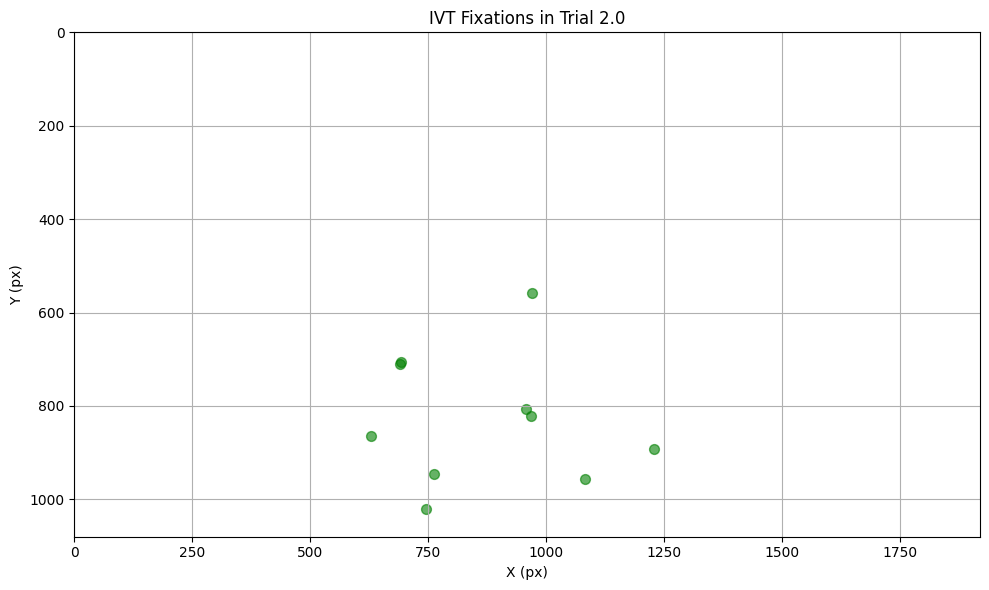

C:\Users\hisao\AppData\Local\Temp\ipykernel_3920\3294026227.py:8: RuntimeWarning: divide by zero encountered in divide
  velocities = np.sqrt(np.diff(xs)**2 + np.diff(ys)**2) / np.diff(timestamps)


**************************************
     start_time      end_time  duration_ms  x_mean_deg  y_mean_deg  trial  \
0  1.732521e+09  1.732521e+09  1967.000008    4.389942    9.425526    3.0   
1  1.732521e+09  1.732521e+09   669.999838    9.824816    7.820523    3.0   
2  1.732521e+09  1.732521e+09  5583.999872   -2.015517    9.007863    3.0   
3  1.732521e+09  1.732521e+09   909.999847    3.975666   10.085474    3.0   
4  1.732521e+09  1.732521e+09  2273.000002   -0.945909    7.054239    3.0   
5  1.732521e+09  1.732521e+09  5217.999935   -2.125732    6.978200    3.0   
6  1.732521e+09  1.732521e+09  1319.999933   -5.717062    6.457065    3.0   
7  1.732521e+09  1.732521e+09  1467.999935   -4.181724    3.085508    3.0   
8  1.732521e+09  1.732521e+09  1309.000015   -3.732940    4.472954    3.0   

          x_px        y_px  
0  1145.794433  941.389310  
1  1379.115191  872.094912  
2   874.829636  923.299554  
3  1128.201774  970.063019  
4   920.041269  839.205780  
5   870.168079  

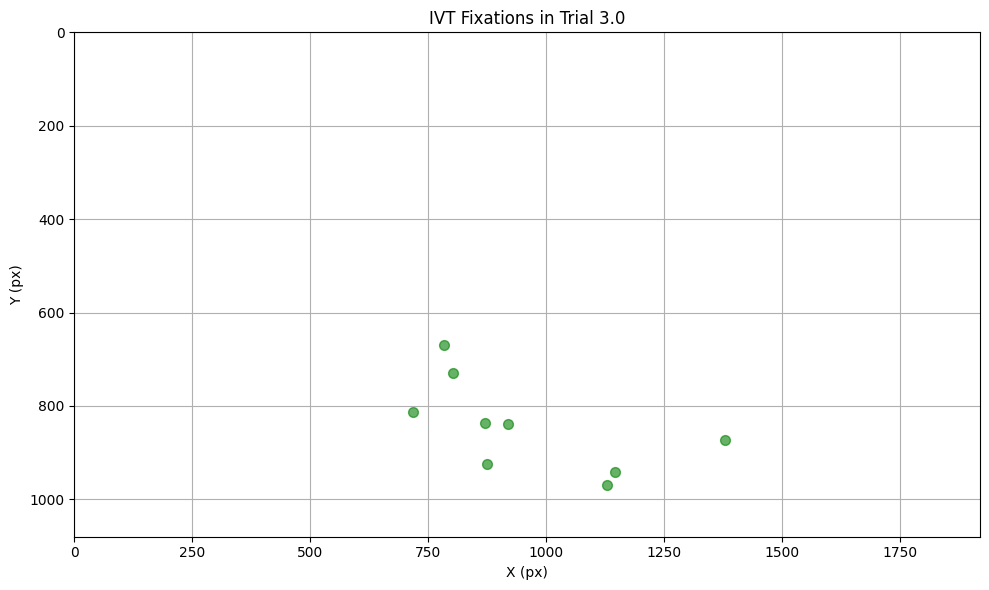

C:\Users\hisao\AppData\Local\Temp\ipykernel_3920\3294026227.py:8: RuntimeWarning: invalid value encountered in divide
  velocities = np.sqrt(np.diff(xs)**2 + np.diff(ys)**2) / np.diff(timestamps)


**************************************
      start_time      end_time   duration_ms  x_mean_deg  y_mean_deg  trial  \
0   1.732521e+09  1.732521e+09    368.999958    4.459716    4.321862    4.0   
1   1.732521e+09  1.732521e+09    460.999966   -4.258374    6.114037    4.0   
2   1.732521e+09  1.732521e+09   8216.000080    4.356313    8.540278    4.0   
3   1.732521e+09  1.732521e+09   2727.999926   -7.914656    4.211912    4.0   
4   1.732521e+09  1.732521e+09    510.999918    5.888711    6.969393    4.0   
5   1.732521e+09  1.732521e+09    319.999933   -1.359201   10.636601    4.0   
6   1.732521e+09  1.732521e+09  10338.000059    0.763108    9.949698    4.0   
7   1.732521e+09  1.732521e+09    272.000074    6.228906   14.197468    4.0   
8   1.732521e+09  1.732521e+09    634.000063   -8.275916    4.225143    4.0   
9   1.732521e+09  1.732521e+09    253.000021   -7.858944    2.471261    4.0   
10  1.732521e+09  1.732521e+09   1430.999994  -10.910387    3.224541    4.0   
11  1.732521e

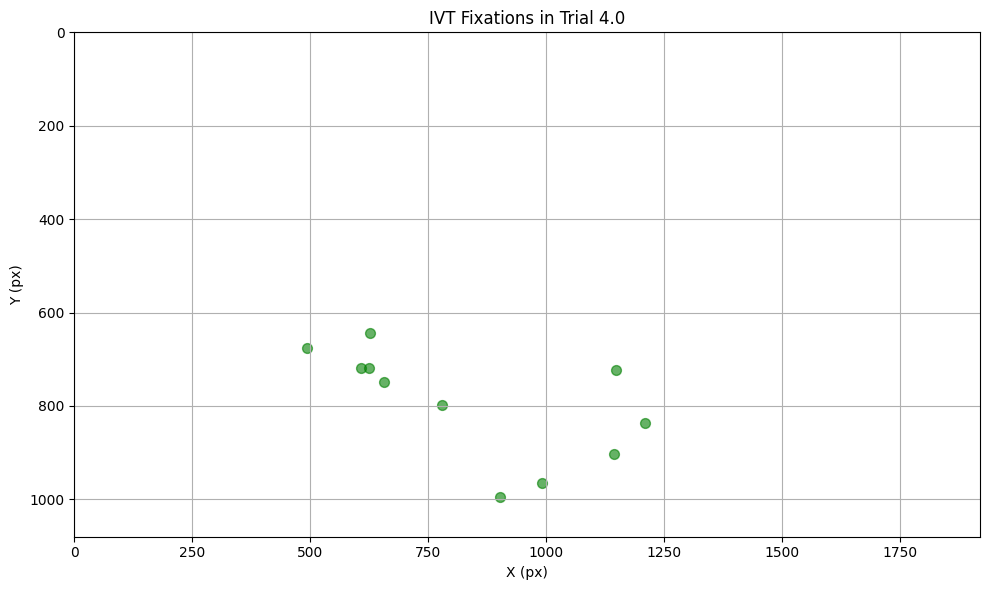

C:\Users\hisao\AppData\Local\Temp\ipykernel_3920\3294026227.py:8: RuntimeWarning: divide by zero encountered in divide
  velocities = np.sqrt(np.diff(xs)**2 + np.diff(ys)**2) / np.diff(timestamps)


**************************************
      start_time      end_time  duration_ms  x_mean_deg  y_mean_deg  trial  \
0   1.732521e+09  1.732521e+09  1204.000235    0.801790    7.876728    5.0   
1   1.732521e+09  1.732521e+09  2538.000107   -7.142832    4.770553    5.0   
2   1.732521e+09  1.732521e+09  1592.999935   -3.664230    5.838503    5.0   
3   1.732521e+09  1.732521e+09   127.000093   11.554184    5.972304    5.0   
4   1.732521e+09  1.732521e+09  2295.000076   -5.551191    2.793617    5.0   
5   1.732521e+09  1.732521e+09   937.999964   -6.773210   11.329298    5.0   
6   1.732521e+09  1.732521e+09  2598.999977   -0.275053    1.229738    5.0   
7   1.732521e+09  1.732521e+09  2726.999998   -3.860298    2.448119    5.0   
8   1.732521e+09  1.732521e+09   245.000124   -5.235617    8.976819    5.0   
9   1.732521e+09  1.732521e+09   526.000023   -0.351137    7.999806    5.0   
10  1.732521e+09  1.732521e+09  1006.000042   -1.184008    1.252022    5.0   
11  1.732521e+09  1.73252

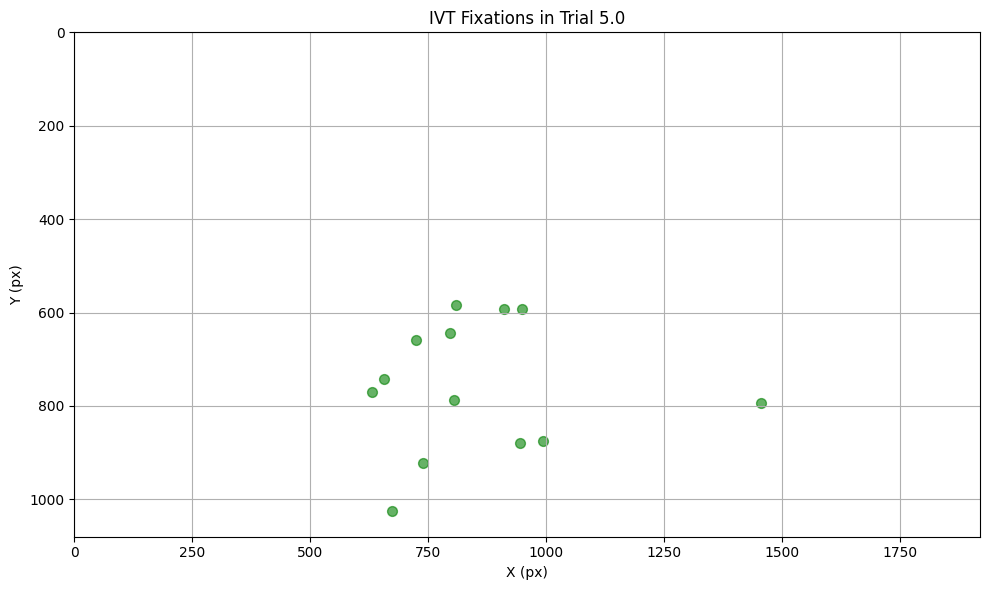

C:\Users\hisao\AppData\Local\Temp\ipykernel_3920\3294026227.py:8: RuntimeWarning: divide by zero encountered in divide
  velocities = np.sqrt(np.diff(xs)**2 + np.diff(ys)**2) / np.diff(timestamps)


**************************************
      start_time      end_time  duration_ms  x_mean_deg  y_mean_deg  trial  \
0   1.732521e+09  1.732521e+09   936.000109    3.362053    8.760440    6.0   
1   1.732521e+09  1.732521e+09  2202.000141   -2.529016    8.399175    6.0   
2   1.732521e+09  1.732521e+09  3608.999968   -4.169230    5.097469    6.0   
3   1.732521e+09  1.732521e+09   335.000038   -3.604002    2.181172    6.0   
4   1.732521e+09  1.732521e+09  1161.999941    0.560597    6.632451    6.0   
5   1.732521e+09  1.732521e+09  3290.999889   -3.768469    4.385929    6.0   
6   1.732521e+09  1.732521e+09  2019.000053   -8.102273    5.942086    6.0   
7   1.732521e+09  1.732521e+09  3053.999901   -3.319909    8.978403    6.0   
8   1.732521e+09  1.732521e+09   589.999914   -6.683533   10.691224    6.0   
9   1.732521e+09  1.732521e+09  1036.999941    1.383196    4.200770    6.0   
10  1.732521e+09  1.732521e+09   557.000160  -10.309449    4.585703    6.0   
11  1.732522e+09  1.73252

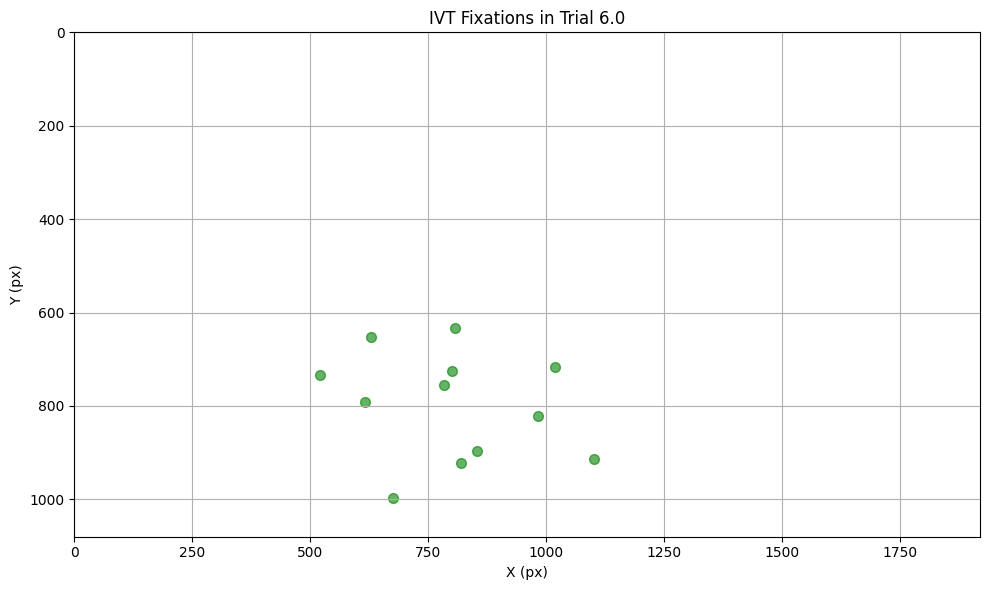

C:\Users\hisao\AppData\Local\Temp\ipykernel_3920\3294026227.py:8: RuntimeWarning: divide by zero encountered in divide
  velocities = np.sqrt(np.diff(xs)**2 + np.diff(ys)**2) / np.diff(timestamps)


**************************************
     start_time      end_time  duration_ms  x_mean_deg  y_mean_deg  trial  \
0  1.732522e+09  1.732522e+09  1562.000036   -7.816099    9.487904    7.0   
1  1.732522e+09  1.732522e+09  1207.999945   -0.046738   11.713886    7.0   
2  1.732522e+09  1.732522e+09  6750.999928   -0.550987    8.463761    7.0   
3  1.732522e+09  1.732522e+09   509.999990  -10.099395    8.862228    7.0   
4  1.732522e+09  1.732522e+09  1338.000059   -6.222850    5.230940    7.0   
5  1.732522e+09  1.732522e+09  1735.999823    0.608275    3.721155    7.0   
6  1.732522e+09  1.732522e+09   430.000067   -4.571688    4.192084    7.0   
7  1.732522e+09  1.732522e+09  2020.999908   -3.636054    6.361735    7.0   
8  1.732522e+09  1.732522e+09   180.999994   -5.050847    3.874049    7.0   
9  1.732522e+09  1.732522e+09   572.000027   -8.668523    6.045383    7.0   

         x_px         y_px  
0  627.785416   944.094721  
1  958.025812  1041.336323  
2  936.725665   899.795821

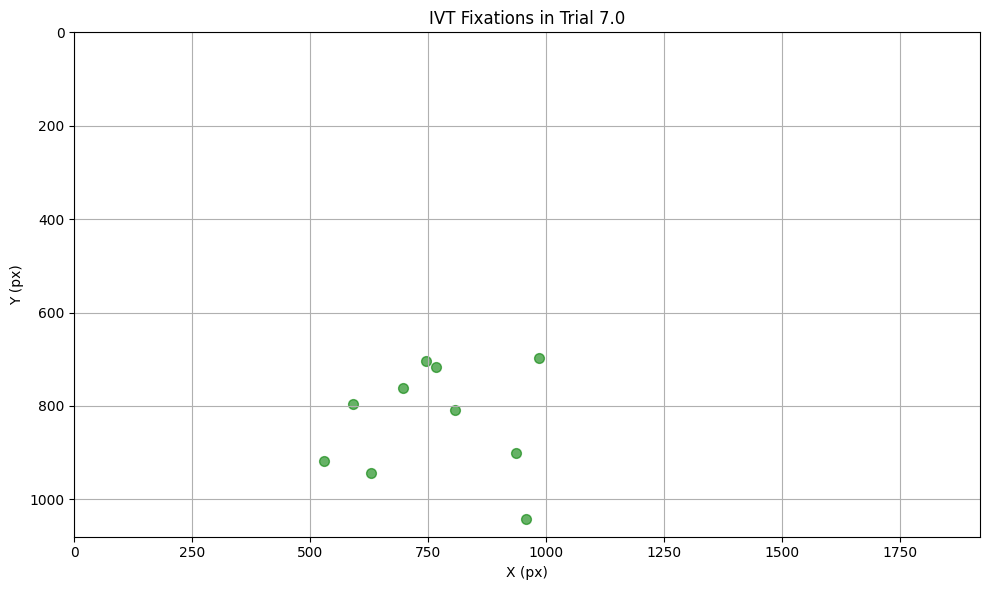

In [7]:
all_fixations = []

for _, row in sampling_df.iterrows():
    t_start = row["start_sec"]
    t_end = row["end_sec"]
    trial_num = row["trial"]

    df_trial = eye_df[(eye_df["epoch_sec"] >= t_start) & (eye_df["epoch_sec"] <= t_end)]
    df_interp = interpolate_missing(df_trial)
    df_interp = df_interp[df_interp["interp_x"].notna() & df_interp["interp_y"].notna()]

    fix_df = detect_fixations_ivt(df_interp)

    if fix_df.empty:
        print(f"Trial {trial_num}: No fixations detected.")
        continue

    fix_df["trial"] = trial_num
    fix_df["x_px"], fix_df["y_px"] = deg2px(fix_df["x_mean_deg"], fix_df["y_mean_deg"])
    all_fixations.append(fix_df)
    
    print("**************************************")
    print(fix_df)

    # プロット
    plt.figure(figsize=(10, 6))
    plt.scatter(fix_df["x_px"], fix_df["y_px"], alpha=0.6, c='green', s=50)
    plt.xlim(0, monitor_resolution_px[0])
    plt.ylim(monitor_resolution_px[1], 0)
    plt.title(f"IVT Fixations in Trial {trial_num }")
    plt.xlabel("X (px)")
    plt.ylabel("Y (px)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
